# Feature extraction using keras with Tensorflow backend

Using a pre-trained VGG16 network (on Imagenet) to extract features and compare differences between samples

In [12]:
from os import path
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from time import sleep
from skimage import io
from PIL import Image
from glob import glob
from sklearn.manifold import TSNE
from sklearn import cluster
from scipy.spatial.distance import cdist
import itertools
from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
model = VGG16(weights='imagenet', include_top=False)

In [3]:
def getX(img_fname):
    img = image.load_img(img_fname, target_size=(224, 224))
    X = image.img_to_array(img)
    X = np.expand_dims(X, axis=0)
    X = preprocess_input(X)
    features = model.predict(X)
    return features.flatten()

Extract VGG16 features for all the images in `datasets/LM_Multipol_Images/`

In [4]:
# Collect all images in folder, keep their path and encode their basename as a label
imgs_path = '/home/jovyan/datasets/LM_Multipol_Images/**/'
img_fnames = glob(path.join(imgs_path,'*.tif'), recursive=True)
labels = [path.basename(i)[:-4] for i in img_fnames]

In [5]:
le = LabelEncoder().fit(labels)
y = le.transform(labels)

In [6]:
# Extract VGG16 features using a pre-trained model on imagenet
X = [getX(i) for i in img_fnames]

In [31]:
tsne = TSNE(n_components=2).fit(X) # Fit t-SNE to inspect distance between feature sets
ms_clf = cluster.MeanShift(n_jobs=-1).fit(X)  # Fit MeanShift to inspect distance between feature sets

Plot distance to clusters showing the images. Dimensionality reduction of VGG16 features using t-SNE

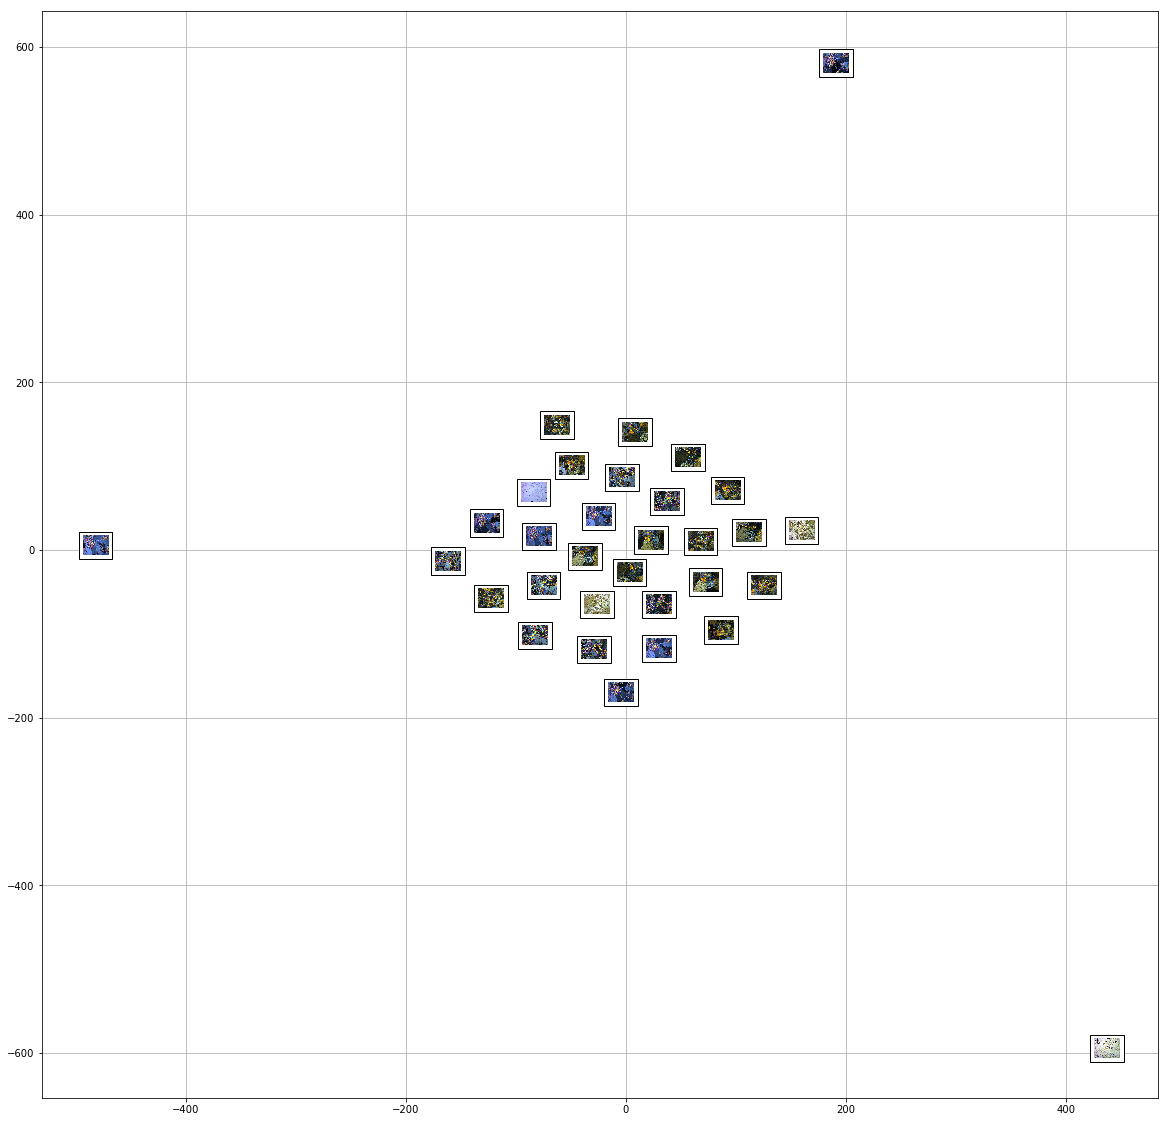

In [32]:
fig, ax = plt.subplots()
fig.set_size_inches(20, 20)

for i, txt in enumerate(labels):
    e_x = tsne.embedding_[i][0]
    e_y = tsne.embedding_[i][1]
#     e_x = ms_clf.cluster_centers_[0][i]
#     e_y = ms_clf.cluster_centers_[1][i]
    ax.scatter(e_x, e_y, c=y[i])
    arr_img = Image.open(img_fnames[i])
    imagebox = OffsetImage(arr_img, zoom=0.01)
    imagebox.image.axes = ax
    ab = AnnotationBbox(imagebox, [e_x,e_y],
        xybox=(1., -1.),
        xycoords='data',
        boxcoords="offset points")                                  
    ax.add_artist(ab)
    ax.grid(True)
    plt.draw()
    sleep(0.1) # Hack to avoid hitting IORate limit
    
plt.show()

Plot distance to clusters. Dimensionality reduction of VGG16 features using t-SNE

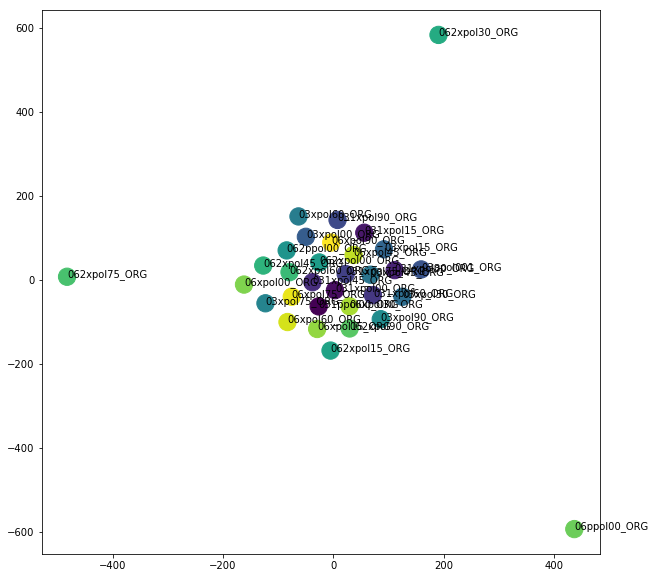

In [43]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
ax.scatter(tsne.embedding_[:,0], tsne.embedding_[:,1], c=y, s=3e2)

for i, txt in enumerate(labels):
    e_x = tsne.embedding_[i][0]
    e_y = tsne.embedding_[i][1]
    ax.annotate(txt, [e_x,e_y])
    
plt.show()

In [95]:
# Useful function (taken from scikit-learn site)
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    plt.figure(figsize=(15,15))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else '.0f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

Normalized confusion matrix


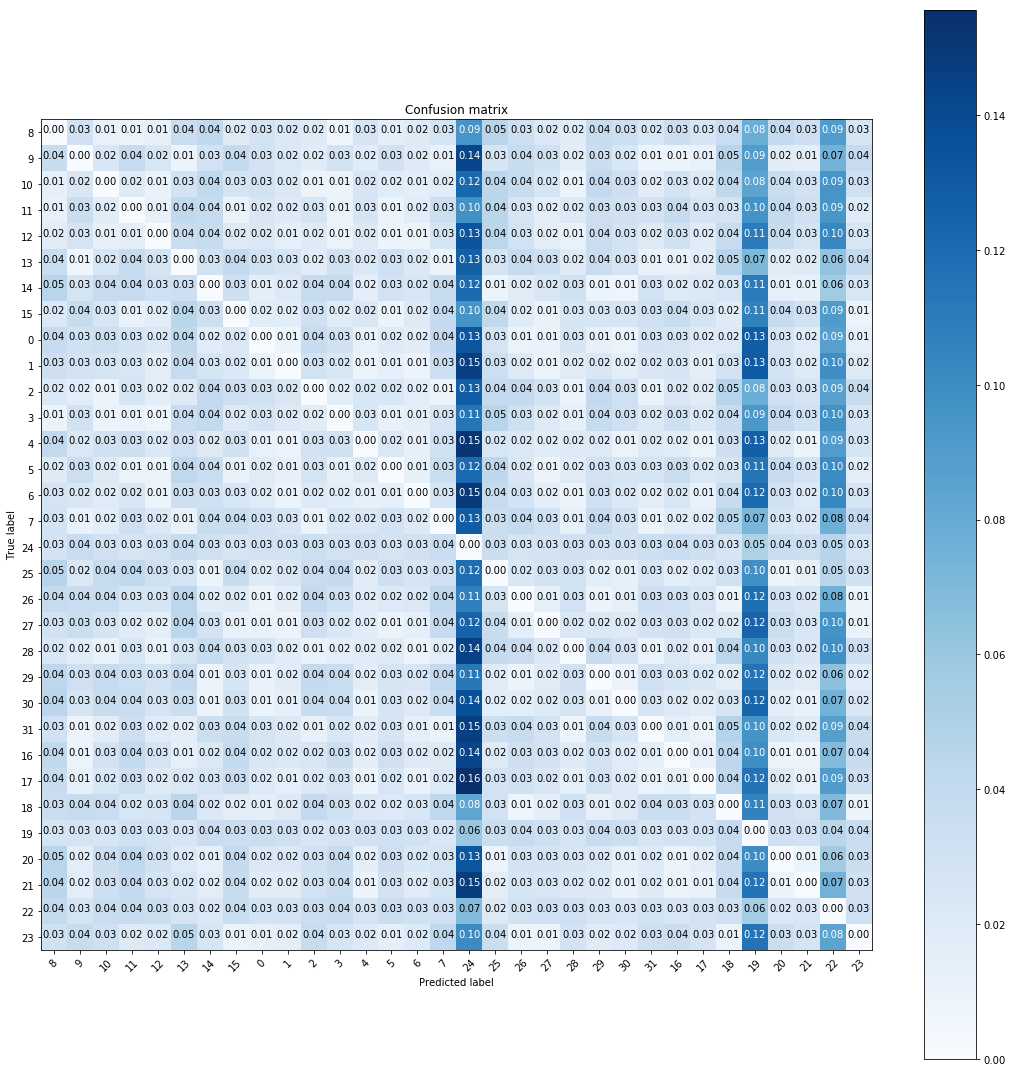

In [97]:
plot_confusion_matrix(cdist(tsne.embedding_, tsne.embedding_,'euclidean'), y, normalize=True)